## Importing libraries

In [1]:
import numpy as np 
import pandas as pd
import plotly as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, plot_confusion_matrix

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)

## Loading dataset

In [2]:
df=pd.read_csv('healthcare-dataset-stroke-data.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


## Preprocessing

### Replacing missing values in bmi column

In [3]:
df.replace(to_replace=np.nan, value=df.bmi.mean(), inplace=True)
df['bmi']= df['bmi'].round(decimals = 1)
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.9,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,28.9,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


### Droping useless columns and seperating features and labels

In [4]:
X = df.drop(['id','stroke','work_type','smoking_status','Residence_type'], axis = 1)
y = df['stroke']

num_cols = X.select_dtypes(include = ['int64', 'efloat64']).columns.to_list()
cat_cols = X.select_dtypes(include = ['object']).columns.to_list()

### Converting categorical features with label encoder and scaling the numerical features

In [5]:
def label_encoder(df):
    for i in cat_cols:
        le = LabelEncoder()
        df[i] = le.fit_transform(df[i])
    return df
X = label_encoder(X)

In [6]:
sc = StandardScaler()
X[num_cols] = sc.fit_transform(X[num_cols])

## Modeling

In [7]:
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

### Splitting the dataset to train and test set and oversampling the minority class only in train set 

In [8]:
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 22)

smote = SMOTE()

X_train_balanced, Y_train_balanced = smote.fit_resample(X_train, y_train)

In [9]:
results = pd.DataFrame(columns = ['SVC', 'LR', 'RF', 'XGB'], index = range(4))

### Support Vector Machines

In [10]:
svc = SVC(random_state = 22, probability = True)
svc.fit(X_train_balanced, Y_train_balanced)
y_pred = svc.predict(X_test)
y_prob = svc.predict_proba(X_test)[:,1]

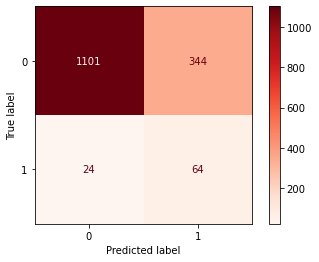

In [11]:
cm_plot = plot_confusion_matrix(svc, X_test, y_test, cmap=plt.cm.Reds)

In [12]:
print('Precision Score: ',round(precision_score(y_test,y_pred),2))
print('Recall Score: ' ,round(recall_score(y_test,y_pred),2))
print('f1 Score: ' ,round(f1_score(y_test,y_pred),2))
print('ROC AUC Score: ' ,round(roc_auc_score(y_test, y_prob), 3))

Precision Score:  0.16
Recall Score:  0.73
f1 Score:  0.26
ROC AUC Score:  0.808


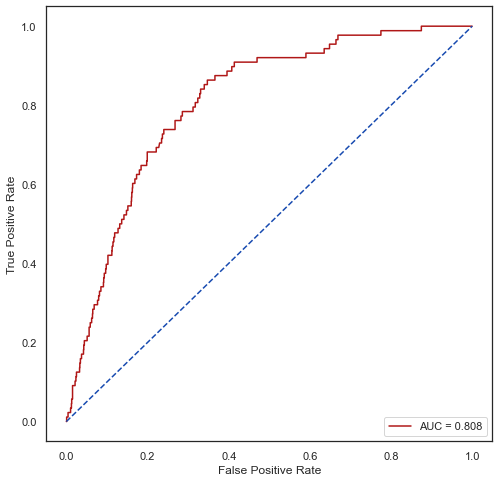

In [13]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Logistic Regression

In [14]:
lg = LogisticRegression(random_state = 22)
lg.fit(X_train_balanced, Y_train_balanced)
y_pred = lg.predict(X_test)
y_prob = lg.predict_proba(X_test)[:,1]

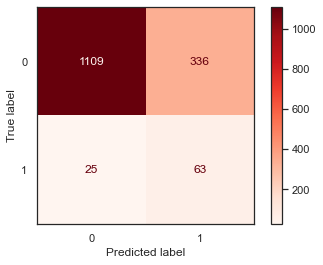

In [15]:
cm_plot = plot_confusion_matrix(lg, X_test, y_test, cmap=plt.cm.Reds)

In [16]:
print('Precision Score: ',round(precision_score(y_test,y_pred),2))
print('Recall Score: ' ,round(recall_score(y_test,y_pred),2))
print('f1 Score: ' ,round(f1_score(y_test,y_pred),2))
print('ROC AUC Score: ' ,round(roc_auc_score(y_test, y_prob), 3))

Precision Score:  0.16
Recall Score:  0.72
f1 Score:  0.26
ROC AUC Score:  0.835


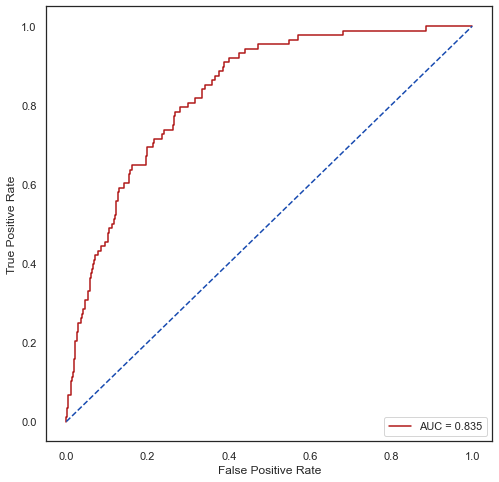

In [17]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Random Forests

In [18]:
rf = RandomForestClassifier(random_state = 22, max_depth = 5)
rf.fit(X_train_balanced, Y_train_balanced)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

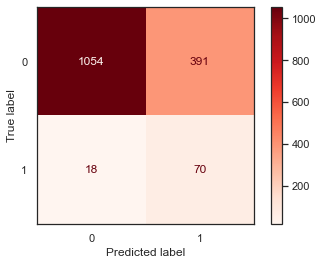

In [19]:
cm_plot = plot_confusion_matrix(rf, X_test, y_test, cmap=plt.cm.Reds)

In [20]:
print('Precision Score: ',round(precision_score(y_test,y_pred),2))
print('Recall Score: ' ,round(recall_score(y_test,y_pred),2))
print('f1 Score: ' ,round(f1_score(y_test,y_pred),2))
print('ROC AUC Score: ' ,round(roc_auc_score(y_test, y_prob), 3))

Precision Score:  0.15
Recall Score:  0.8
f1 Score:  0.26
ROC AUC Score:  0.829


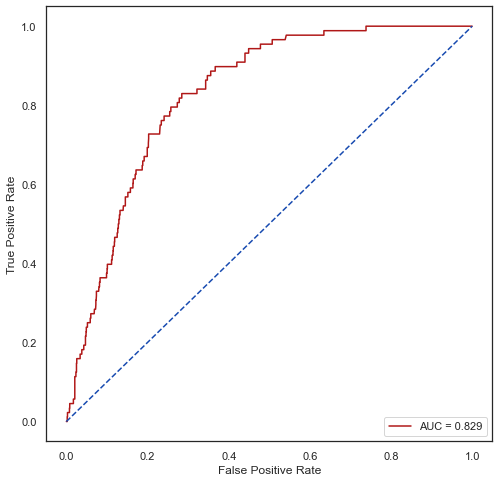

In [21]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
x1=false_positive_rate
y1=true_positive_rate
sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Gradient Boosting

In [22]:
gbc = GradientBoostingClassifier(random_state = 22, n_estimators=100, learning_rate=1.0, max_depth=1)
gbc.fit(X_train_balanced, Y_train_balanced)
y_pred = gbc.predict(X_test)
y_prob = gbc.predict_proba(X_test)[:,1]

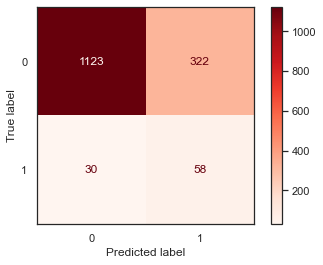

In [23]:
cm_plot = plot_confusion_matrix(gbc, X_test, y_test, cmap=plt.cm.Reds)

In [24]:
print('Precision Score: ',round(precision_score(y_test,y_pred),2))
print('Recall Score: ' ,round(recall_score(y_test,y_pred),2))
print('f1 Score: ' ,round(f1_score(y_test,y_pred),2))
print('ROC AUC Score: ' ,round(roc_auc_score(y_test, y_prob), 3))

Precision Score:  0.15
Recall Score:  0.66
f1 Score:  0.25
ROC AUC Score:  0.803


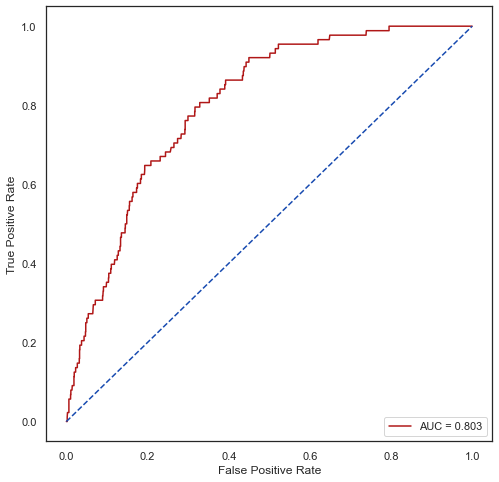

In [25]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()